### Library

In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from collections import Counter

warnings.filterwarnings('ignore')
sys.path.append('..')
from src.utils import setup_workspace, seed, get_device

In [2]:
PROJECT_ROOT = "/Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation"
SEED = 42

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

Env: Local | Root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Device: mps


device(type='mps')

In [3]:
from src.data.dataset import DatasetLoader

DATA_ROOT = Path("dataset/Multi Camera Semantic Segmentation")

# Train data
train_dataset = DatasetLoader(
    data_root=DATA_ROOT,
    split="train",
    camera="left",
)

# Val data
val_dataset = DatasetLoader(
    data_root=DATA_ROOT,
    split="val",
    camera="left",
)

Train samples: 516
Val samples: 182


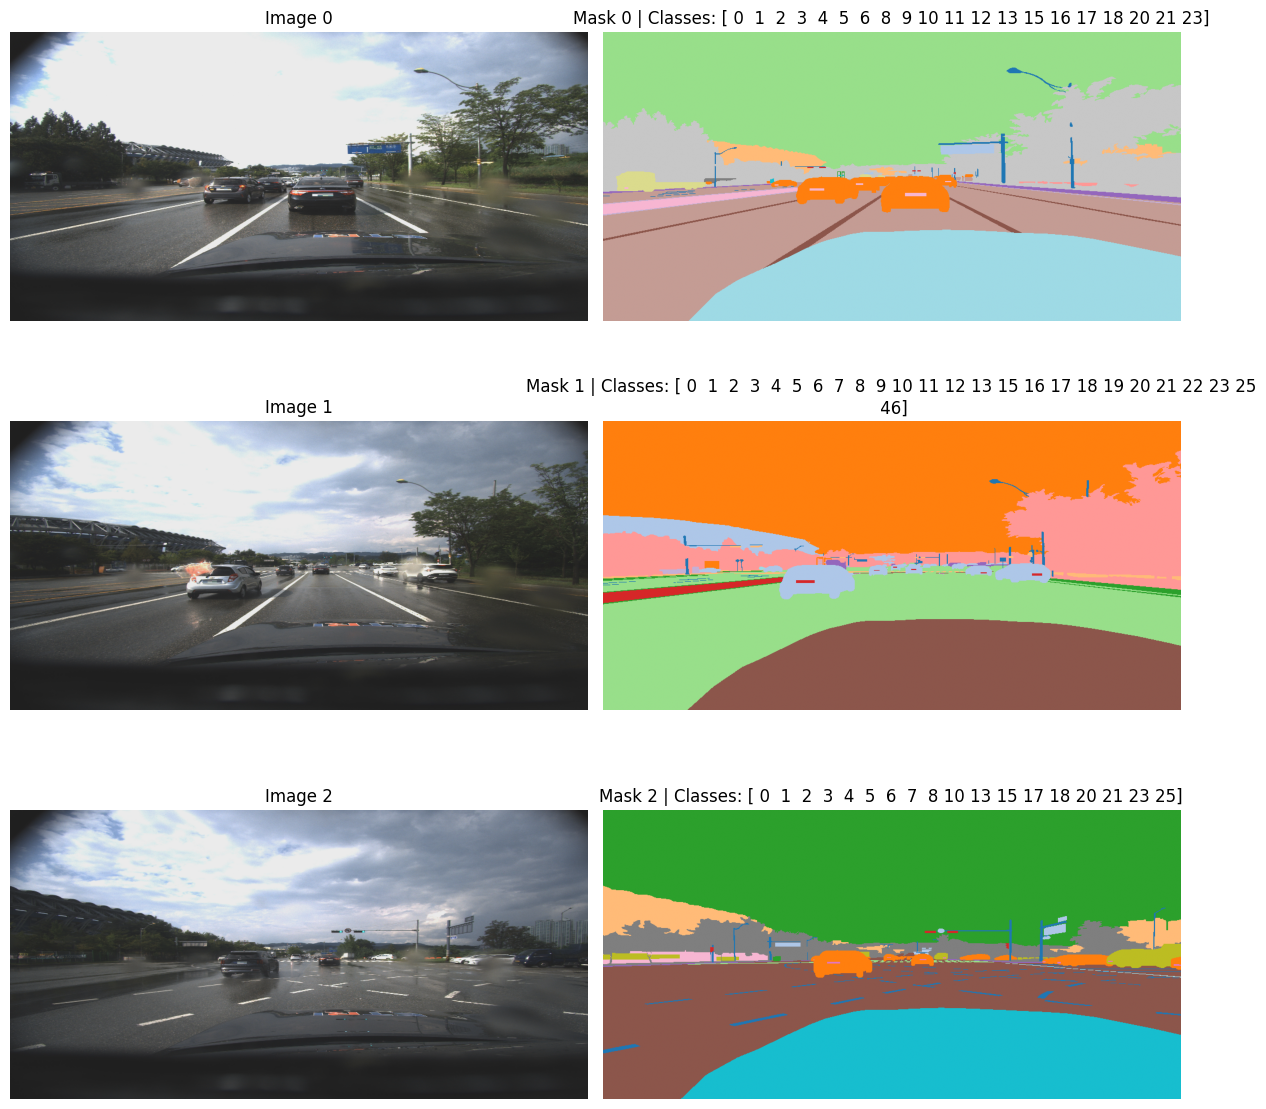

In [4]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    img, mask = train_dataset[i]

    # tensor → numpy (C, H, W) → (H, W, C)
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # 이미지
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image {i}")
    axes[i, 0].axis("off")

    # 마스크
    axes[i, 1].imshow(mask_np, cmap="tab20")
    axes[i, 1].set_title(f"Mask {i} | Classes: {np.unique(mask_np)}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

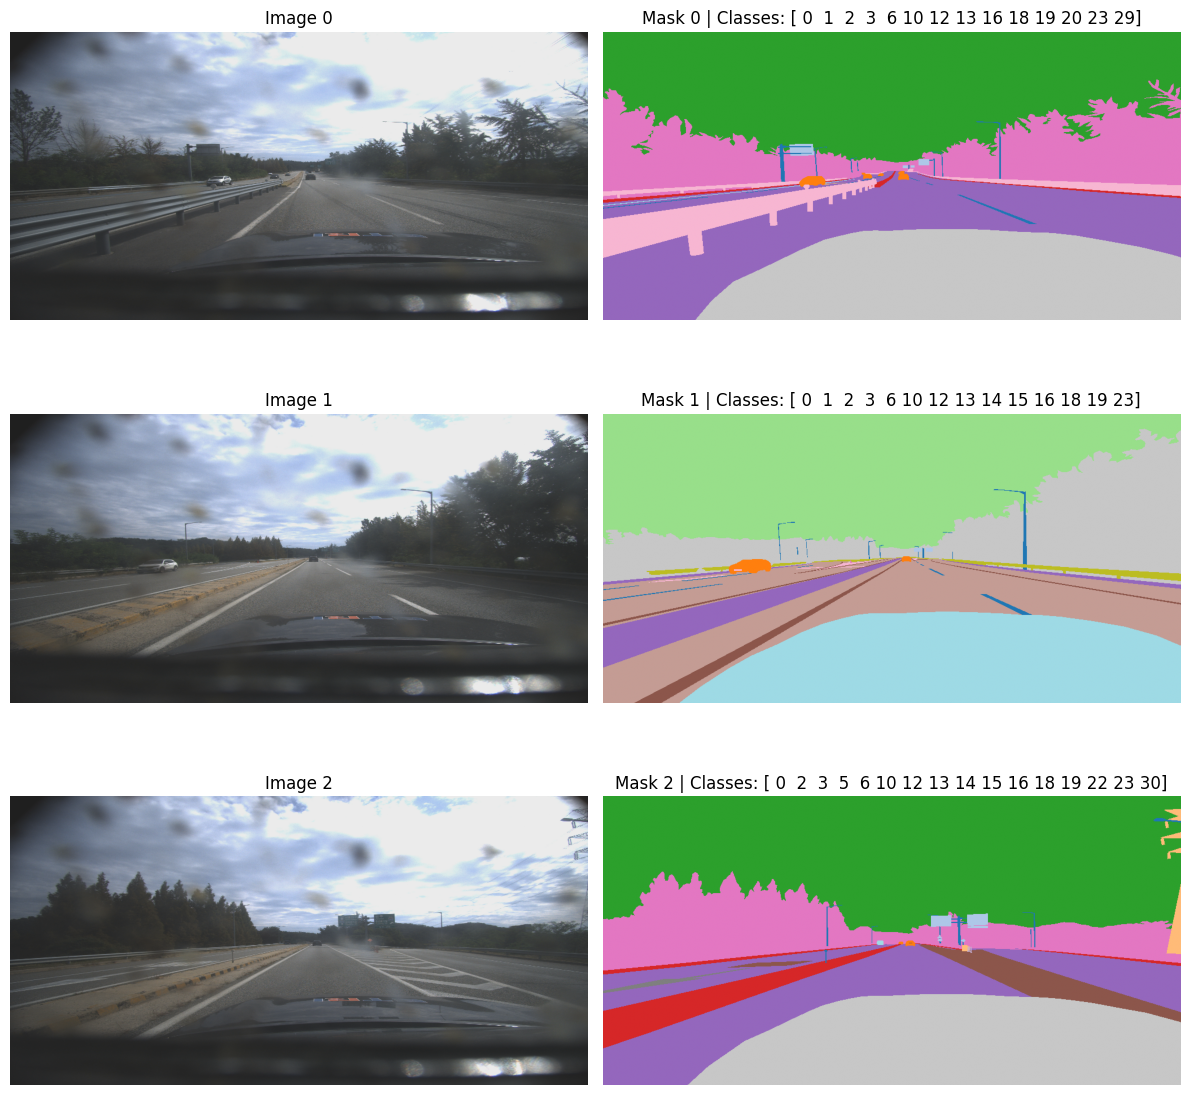

In [5]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    img, mask = val_dataset[i]

    # tensor → numpy (C, H, W) → (H, W, C)
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # 이미지
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image {i}")
    axes[i, 0].axis("off")

    # 마스크
    axes[i, 1].imshow(mask_np, cmap="tab20")
    axes[i, 1].set_title(f"Mask {i} | Classes: {np.unique(mask_np)}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# from src.data.dataset import generate_class_info
# class_info = generate_class_info(DATA_ROOT)
# class_info

class_info = pd.read_csv(f"{DATA_ROOT}/class_info.csv")
class_info

,class_id,class_name,count
0,0,pole,14713
1,1,whdot,6806
2,2,traffic sign,5151
3,3,car,3900
4,4,building,3427
...,...,...,...
57,57,right-forward,2
58,58,trailer,1
59,59,number 1,1
60,60,polegroup,1


In [ ]:
from src.data.dataset import get_dataset_info

train_df = get_dataset_info(DATA_ROOT, split="train")
val_df = get_dataset_info(DATA_ROOT, split="val")
df = pd.concat([train_df, val_df], ignore_index=True)
df.head()

Loading val: 100%|██████████| 182/182 [00:00<00:00, 954.55it/s] 


,img_path,label_path,folder,split,width,height,classes,num_objects,unique_classes,num_classes
0,dataset/Multi Camera Semantic Segmentation/lef...,dataset/Multi Camera Semantic Segmentation/lab...,20220817_153937,train,2048,1536,"[sky, vegetation, building, building, building...",98,"[traffic light, sky, license plate, car, ego v...",20
1,dataset/Multi Camera Semantic Segmentation/lef...,dataset/Multi Camera Semantic Segmentation/lab...,20220817_153937,train,2048,1536,"[sky, vegetation, vegetation, road, building, ...",142,"[traffic light, sky, license plate, car, ego v...",25
2,dataset/Multi Camera Semantic Segmentation/lef...,dataset/Multi Camera Semantic Segmentation/lab...,20220817_153937,train,2048,1536,"[sky, vegetation, building, building, building...",164,"[traffic light, sky, license plate, car, pole,...",18
3,dataset/Multi Camera Semantic Segmentation/lef...,dataset/Multi Camera Semantic Segmentation/lab...,20220817_153937,train,2048,1536,"[sky, vegetation, building, building, building...",130,"[traffic light, sky, license plate, car, ego v...",20
4,dataset/Multi Camera Semantic Segmentation/lef...,dataset/Multi Camera Semantic Segmentation/lab...,20220817_153937,train,2048,1536,"[sky, vegetation, building, building, building...",158,"[traffic light, sky, license plate, car, ego v...",24


### Class Imbalnce

Total classes: 62


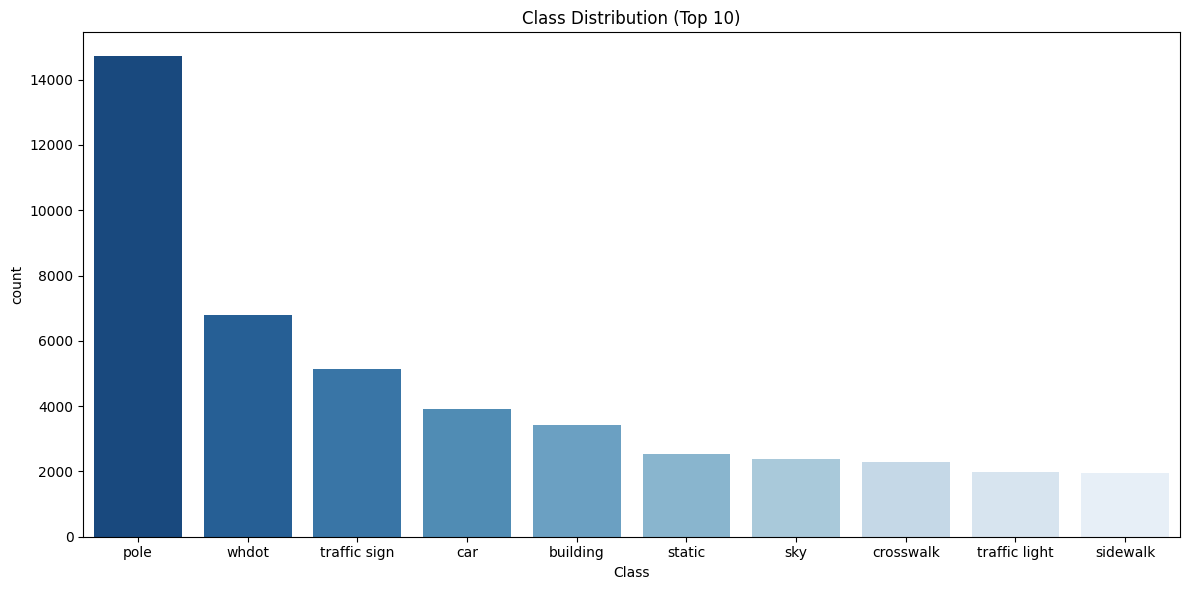

In [ ]:
all_classes = []
for classes in df['classes']:
    all_classes.extend(classes)

# 클래스별 등장 횟수
class_counts = Counter(all_classes)
class_df = pd.DataFrame(
    class_counts.most_common(),
    columns=['class', 'count']
)
class_df['ratio'] = class_df['count'] / class_df['count'].sum() * 100
print(f"Total classes: {len(class_df)}")

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=class_df['class'][:10], y=class_df['count'][:10], palette='Blues_r')
plt.xlabel('Class')
plt.title('Class Distribution (Top 10)')
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

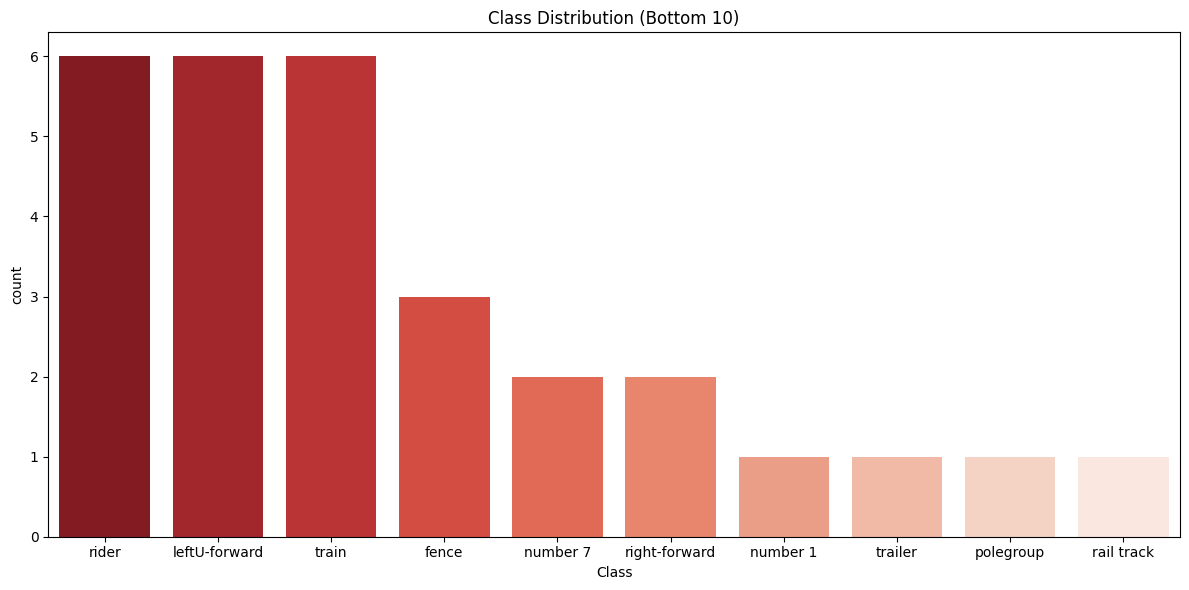

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=class_df['class'][-10:], y=class_df['count'][-10:], palette='Reds_r')
plt.xlabel('Class')
plt.title('Class Distribution (Bottom 10)')
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 이미지당 객체 수 분석

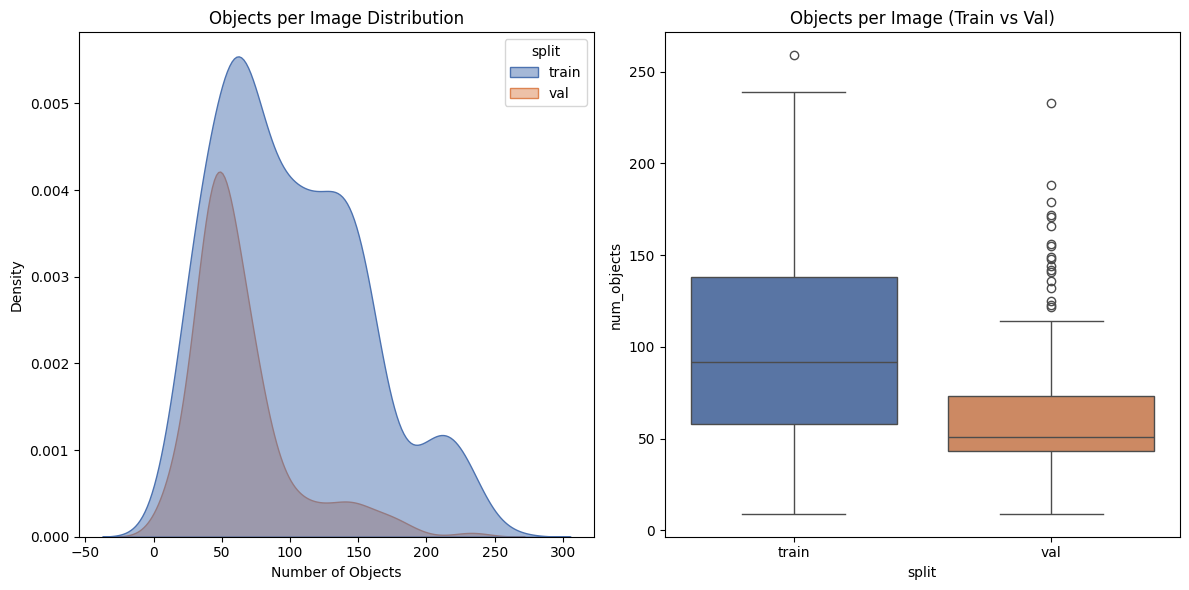

In [ ]:
palette = {
    "train": "#4C72B0",  # 파랑
    "val": "#DD8452"     # 주황
}

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=df,
    x="num_objects",
    hue="split",
    fill=True,
    alpha=0.5,
    palette=palette
)
plt.xlabel("Number of Objects")
plt.ylabel("Density")
plt.title("Objects per Image Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(
    x="split",
    y="num_objects",
    data=df,
    hue="split",
    palette=palette,
    legend=False
)
plt.title("Objects per Image (Train vs Val)")

plt.tight_layout()
plt.show()

### 차선 클래스 분석

차선 관련 클래스 수: 8


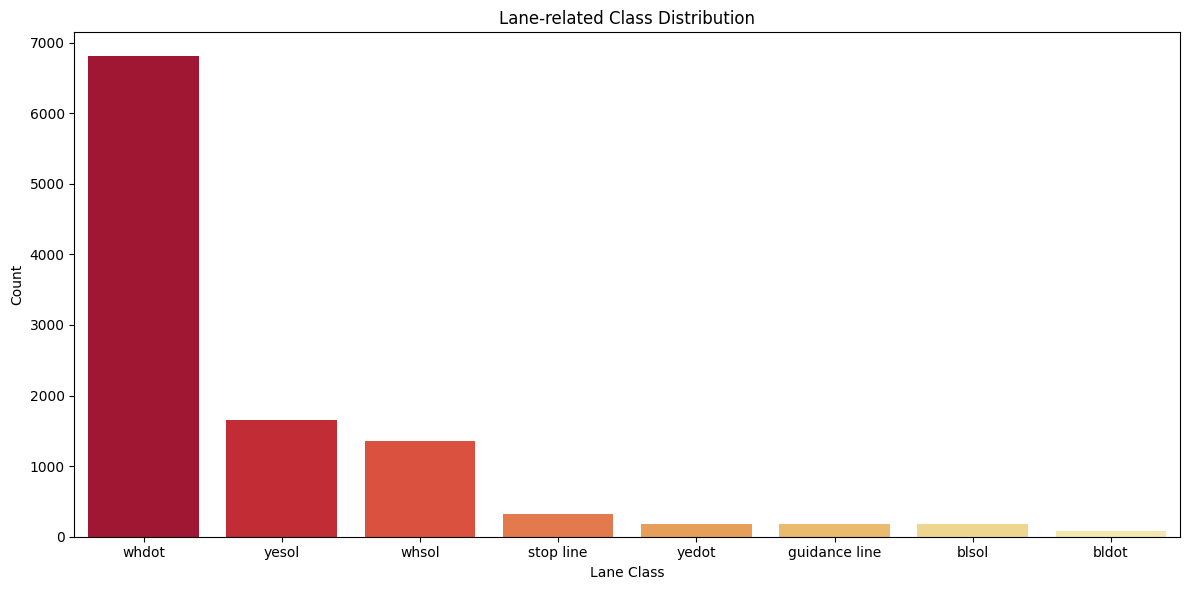

In [ ]:
# 차선 관련 클래스 필터링
lane_keywords = ['lane', 'sol', 'dot', 'line', 'wh', 'ye', 'bl']

lane_classes = [cls for cls in class_df['class']
                if any(kw in cls.lower() for kw in lane_keywords)]

lane_df = class_df[class_df['class'].isin(lane_classes)]
print(f"차선 관련 클래스 수: {len(lane_df)}")

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='class', y='count', data=lane_df, palette='YlOrRd_r')
plt.xlabel('Lane Class')
plt.ylabel('Count')
plt.title('Lane-related Class Distribution')
plt.tight_layout()
plt.show()

In [ ]:
pixel_counts = Counter()
error_count = 0
error_files = []

for i in tqdm(range(len(train_dataset)), desc="Train"):
    try:
        _, mask = train_dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for cls_id, cnt in zip(unique, counts):
            pixel_counts[cls_id] += cnt
    except Exception as e:
        error_count += 1
        error_files.append(train_dataset.get_sample_info(i)['img_path'])

for i in tqdm(range(len(val_dataset)), desc="Val"):
    try:
        _, mask = val_dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for cls_id, cnt in zip(unique, counts):
            pixel_counts[cls_id] += cnt
    except Exception as e:
        error_count += 1
        error_files.append(val_dataset.get_sample_info(i)['img_path'])

print(f"\nTotal errors: {error_count} / {len(train_dataset) + len(val_dataset)}")

Val: 100%|██████████| 182/182 [00:08<00:00, 22.25it/s]


Total errors: 1 / 698


### 클래스별 픽셀 비율 (Top 10)

- 전체 이미지에서 각 클래스가 차지하는 총 면적 비율

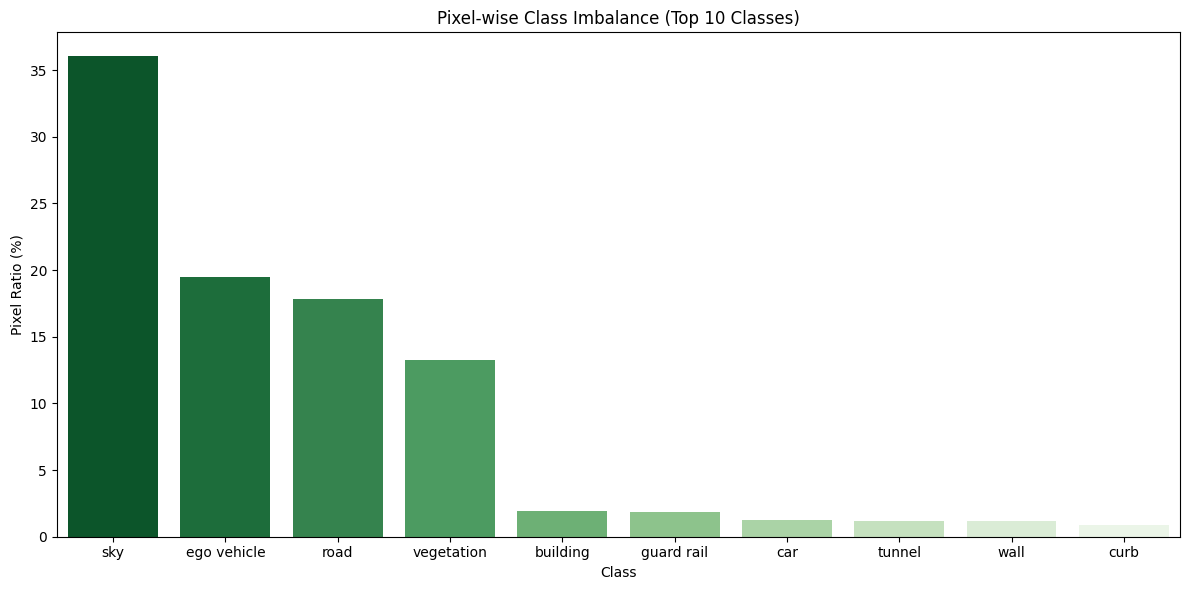

In [ ]:
pixel_df = pd.DataFrame(pixel_counts.most_common(), columns=['class_id', 'pixel_count'])
pixel_df['ratio'] = pixel_df['pixel_count'] / pixel_df['pixel_count'].sum() * 100

# class name 매핑
class_info = pd.read_csv(f"{DATA_ROOT}/class_info.csv")
id_to_name = dict(zip(class_info['class_id'], class_info['class_name']))
pixel_df['class_name'] = pixel_df['class_id'].map(id_to_name)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=pixel_df['class_name'][:10], y=pixel_df['ratio'][:10], palette='Greens_r')
plt.xlabel('Class')
plt.ylabel('Pixel Ratio (%)')
plt.title("Pixel-wise Class Imbalance (Top 10 Classes)")
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

df = pd.read_csv("../dataset/multi_class_info.csv")
df

,class_id,class_name,count
0,0,pole,14713
1,1,whdot,6806
2,2,traffic sign,5151
3,3,car,3900
4,4,building,3427
...,...,...,...
57,57,right-forward,2
58,58,trailer,1
59,59,number 1,1
60,60,polegroup,1


In [4]:
df['class_name'].unique()

array(['pole', 'whdot', 'traffic sign', 'car', 'building', 'static',
       'sky', 'crosswalk', 'traffic light', 'sidewalk', 'curb', 'yesol',
       'whsol', 'road', 'rubber cone', 'license plate',
       'general road mark', 'wall', 'vegetation', 'guard rail', 'truck',
       'dynamic', 'forward', 'ego vehicle', 'protection zone',
       'stop line', 'yedot', 'left', 'guidance line', 'blsol', 'bus',
       'bridge', 'right', 'person', 'ground', 'bldot', 'tunnel',
       'number 0', 'parking', 'leftU', 'speed bump',
       'prohibition (X mark)', 'bicycle', 'number 5', 'number 6',
       'caravan', 'motorcycle', 'terrain', 'number 4', 'ground animal',
       'water', 'number 3', 'train', 'leftU-forward', 'rider', 'fence',
       'number 7', 'right-forward', 'trailer', 'number 1', 'polegroup',
       'rail track'], dtype=object)

In [5]:
cnt1 = df[df['count'] <= 1]
cnt1

,class_id,class_name,count
58,58,trailer,1
59,59,number 1,1
60,60,polegroup,1
61,61,rail track,1


In [6]:
df.describe()

,class_id,count
count,62.000000,62.000000
mean,30.500000,1021.483871
std,18.041619,2202.221574
min,0.000000,1.000000
25%,15.250000,11.250000
50%,30.500000,158.500000
75%,45.750000,1149.000000
max,61.000000,14713.000000


In [15]:
q_25 = df[['count']].describe().T['25%']
q_25.dtype

dtype('float64')

In [ ]:
from turtle import Turtle

q_25 = df['count'].quantile(0.25)
df_q_25 = df[df['count'] <= q_25].reset_index(drop=True)
df_q_25

,class_id,class_name,count
0,46,motorcycle,11
1,47,terrain,10
2,48,number 4,10
3,49,ground animal,9
4,50,water,9
5,51,number 3,8
6,52,train,6
7,53,leftU-forward,6
8,54,rider,6
9,55,fence,3


In [22]:
mean = df['count'].mean()
df_mean = df[df['count'] < mean].reset_index(drop=True)
df_mean

,class_id,class_name,count
0,18,vegetation,1004
1,19,guard rail,956
2,20,truck,919
3,21,dynamic,870
4,22,forward,699
5,23,ego vehicle,696
6,24,protection zone,338
7,25,stop line,317
8,26,yedot,187
9,27,left,186
